In [53]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [54]:
data = pd.read_csv('tracking_data.csv')
data.head()

,Unnamed: 0,playId,frame.id,OL_1_x,OL_1_y,OL_2_x,OL_2_y,OL_3_x,OL_3_y,OL_4_x,...,Def_7_y,Def_8_x,Def_8_y,Def_9_x,Def_9_y,Def_10_x,Def_10_y,Def_11_x,Def_11_y,PlayResult
0,1,68,1,74.18,32.85,73.97,26.61,74.04,31.15,73.41,...,24.31,71.53,9.49,69.90,30.90,67.83,36.05,72.36,27.68,0
1,2,68,2,74.18,32.84,73.97,26.61,74.04,31.15,73.41,...,24.30,71.53,9.49,70.03,30.80,67.85,36.00,72.37,27.68,0
2,3,68,3,74.18,32.84,73.97,26.61,74.04,31.15,73.42,...,24.30,71.53,9.49,70.16,30.71,67.87,35.95,72.37,27.67,0
3,4,68,4,74.18,32.84,73.97,26.61,74.04,31.15,73.42,...,24.29,71.53,9.49,70.28,30.62,67.91,35.91,72.37,27.67,0
4,5,68,5,74.18,32.84,73.97,26.61,74.04,31.15,73.43,...,24.28,71.52,9.49,70.40,30.54,67.96,35.88,72.37,27.66,0


In [55]:
data.columns

Index(['Unnamed: 0', 'playId', 'frame.id', 'OL_1_x', 'OL_1_y', 'OL_2_x',
       'OL_2_y', 'OL_3_x', 'OL_3_y', 'OL_4_x', 'OL_4_y', 'OL_5_x', 'OL_5_y',
       'Off_1_x', 'Off_1_y', 'Off_2_x', 'Off_2_y', 'Off_3_x', 'Off_3_y',
       'Off_4_x', 'Off_4_y', 'Off_5_x', 'Off_5_y', 'Off_6_x', 'Off_6_y',
       'Def_1_x', 'Def_1_y', 'Def_2_x', 'Def_2_y', 'Def_3_x', 'Def_3_y',
       'Def_4_x', 'Def_4_y', 'Def_5_x', 'Def_5_y', 'Def_6_x', 'Def_6_y',
       'Def_7_x', 'Def_7_y', 'Def_8_x', 'Def_8_y', 'Def_9_x', 'Def_9_y',
       'Def_10_x', 'Def_10_y', 'Def_11_x', 'Def_11_y', 'PlayResult'],
      dtype='object')

In [56]:
nan_counts = data.isna().sum()
print(f"Columns with nan values:\n{nan_counts[nan_counts > 0]}") 

Columns with nan values:
Def_7_x    6
Def_7_y    6
dtype: int64


In [57]:
data.dropna(inplace=True)
nan_counts = data.isna().sum()
print(f'Number of nan\'s: {nan_counts[nan_counts > 0].size}')

Number of nan's: 0


In [58]:
num_plays = data["playId"].unique()
print(f'Number of unique plays: {num_plays.size}')

Number of unique plays: 138


In [59]:
play_id = num_plays[0]
play = data[data["playId"] == play_id]
print(f'Number of frames for play {play_id}: {play["frame.id"].values.size}')

Number of frames for play 68: 87


In [60]:
frame_1 = play[play["frame.id"] == 1]
x_cols = [c for c in frame_1.columns if '_x' in c.lower()]
y_cols = [c for c in frame_1.columns if '_y' in c.lower()]
points = [(frame_1[x][0], frame_1[y][0], re.findall(r'^(.*?)_', x.lower())[0]) for x, y in zip(x_cols, y_cols)]
points

[(74.18, 32.85, 'ol'),
 (73.97, 26.61, 'ol'),
 (74.04, 31.15, 'ol'),
 (73.41, 29.9, 'ol'),
 (73.84, 28.34, 'ol'),
 (73.91, 34.78, 'off'),
 (74.36, 29.74, 'off'),
 (74.63, 19.35, 'off'),
 (75.36, 29.92, 'off'),
 (79.02, 29.66, 'off'),
 (74.08, 9.46, 'off'),
 (64.62, 18.19, 'def'),
 (72.0, 33.45, 'def'),
 (72.18, 36.06, 'def'),
 (69.47, 26.92, 'def'),
 (57.51, 28.94, 'def'),
 (71.76, 30.19, 'def'),
 (71.98, 24.31, 'def'),
 (71.53, 9.49, 'def'),
 (69.9, 30.9, 'def'),
 (67.83, 36.05, 'def'),
 (72.36, 27.68, 'def')]

In [61]:
x = [p[0] for p in points]
y = [p[1] for p in points]
label = [p[2] for p in points]
df = pd.DataFrame(dict(x=x, y=y, label=label))
groups = df.groupby('label')
df.head()

,x,y,label
0,74.18,32.85,ol
1,73.97,26.61,ol
2,74.04,31.15,ol
3,73.41,29.90,ol
4,73.84,28.34,ol


In [62]:
def draw_football_field(ax):
    ax.set_xlim([0, 120])
    ax.set_ylim([0, 160/3])
    ax.set_facecolor('green')
    ax.fill_between([0, 10], 160/3, color='maroon')
    ax.fill_between([110, 120], 160/3, color='gold')
    
    for i in range(1, 12):
        ax.axvline(i*10, c='white', zorder=0)
        if i < 6:
            ax.annotate(i*10, ((i+1)*10+1, 5), c='white')
        elif i < 10:
            ax.annotate(100 - i*10, ((i+1)*10+1, 5), c='white')
            

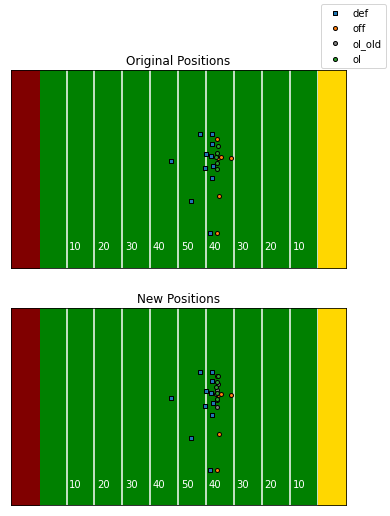

In [63]:
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True, sharey=True)
for ax in axs:
    draw_football_field(ax)

marker_size = 16
edge_color = 'black'
for name, group in groups:
    if name == 'def':
        m = 's'
    else:
        m = 'o'
    axs[0].scatter(group.x, group.y, label=name, marker=m, 
                   s=marker_size, edgecolors=edge_color)
    
for name, group in groups:
    if name == 'def':
        m = 's'
    else:
        m = 'o'
    if name == 'ol':
        axs[1].scatter(group.x, group.y, label=f'{name}_old', 
                       marker=m, edgecolors=edge_color, color='gray', 
                       s=marker_size)
        axs[1].scatter(group.x, group.y+2, label=name, 
                       edgecolors=edge_color, marker=m, s=marker_size)
    else: 
        axs[1].scatter(group.x, group.y, label=name, 
                       marker=m, s= marker_size, edgecolors=edge_color)

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
axs[0].title.set_text('Original Positions')
axs[1].title.set_text('New Positions')
plt.xticks([])
plt.yticks([])
# plt.legend(loc='upper right')
plt.savefig('C:/Users/ian_c/Linesman/football_fields/ol_plus_2_in_y_direction.svg')